# Punto 3

Entrenar una red neuronal para clasificación de palabras. Utiliza los embeddings previamente generados para entrenar una red neuronal simple que clasifique palabras según su contexto o relación con los personajes principales en los textos. 
La arquitectura de la red debe incluir una capa de embeddings, seguida de capas de densidad totalmente conectadas (fully connected), con una función de activación relu en cada capa oculta, y una función de activación softmax en la capa de salida.
Se deben dividir los datos en conjuntos de entrenamiento y prueba, y reportar las métricas de rendimiento (precisión, recall, y F1) para evaluar el modelo.

Importación de bibliotecas y dependencias a usar en el ejercicio

In [2]:
import os
import re
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import string
from sklearn.calibration import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
from gensim.models import KeyedVectors

La implementación de esta función está diseñada para limpiar el texto de los libros del Proyecto Gutenberg, eliminando marcas específicas del Proyecto, los nombres de autores y otras secciones que no son relevantes para el análisis. Esto deja un texto más puro que puede ser procesado posteriormente para tareas como el análisis de texto, tokenización, o modelado de lenguaje.

In [3]:
def clean_gutenberg_text(text):
    # Eliminar el encabezado del Proyecto Gutenberg que aparece al inicio del libro
    text = re.sub(r'^.*?\*\*\* START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*', '', text, flags=re.DOTALL)
    # Eliminar el pie del Proyecto Gutenberg que aparece al final del libro
    text = re.sub(r'\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*?$', '', text, flags=re.DOTALL)
    authors = r'William Oberfield|James Branch Cabell|Wilhelm Raabe'
    # Eliminar menciones de autores específicos y las líneas relacionadas con ellos
    text = re.sub(r'(?i)\b(?:' + authors + r')\b.*?(?=\n)', '', text, flags=re.DOTALL)
    # Eliminar las secciones de producción, metadatos y créditos del libro
    text = re.sub(r'(Produced by.*?Distributed Proofreaders|Title:.*?Author:.*?Release date:.*?Language:.*?Credits:.*?Project Gutenberg Distributed Proofreaders)', '', text, flags=re.DOTALL)
    # Eliminar las secciones de contenido, bibliografía e índice
    text = re.sub(r'(CONTENTS.*?THE AFTERWORD|BIBLIOGRAPHY|INDEX)', '', text, flags=re.DOTALL)
    text = re.sub(r'\n+', '\n', text)
    text = text.strip()
    
    return text

Esta implementación, cumple dos propósitos:

1. La función load_embeddings carga los archivos de embeddings usando KeyedVectors.
2. El diccionario embedding_file_paths guarda las rutas de los archivos de embeddings para tres tamaños (300, 400, 500 dimensiones).

In [4]:
def load_embeddings(file_path):
    return KeyedVectors.load(file_path)

embedding_file_paths = {
    300: 'Books_300_G4.model',
    400: 'Books_400_G4.model',
    500: 'Books_500_G4.model', 
}

La función split_into_segments toma un texto largo y lo divide en segmentos de un tamaño de palabras fijo.
El tamaño de los segmentos se controla mediante el parámetro segment_size.
Esta implementación es útil cuando se quiere dividir un texto largo en partes manejables para procesamiento posterior, como en tareas de NLP.

In [5]:
def split_into_segments(text, segment_size=200):
    words = text.split() 
    segments = [' '.join(words[i:i + segment_size]) for i in range(0, len(words), segment_size)]
    return segments

La siguiente implementación,recorre un directorio de libros organizados por autor, limpia el contenido de los libros, divide el texto en segmentos de tamaño fijo y devuelve una lista de segmentos junto con la lista de autores correspondientes a esos segmentos. Esto es útil para la preparación de datos en tareas de procesamiento de lenguaje natural (NLP).

In [6]:
def load_books_data(base_path='books', segment_size=200):
    texts = []
    labels = []
    # Obtiene la lista de autores (subdirectorios o archivos en la carpeta 'base_path')
    authors = os.listdir(base_path)

    for author in authors:
        author_path = os.path.join(base_path, author)
        for book_file in os.listdir(author_path):
            # Abre el archivo de texto en modo lectura con codificación 'utf-8'.
            with open(os.path.join(author_path, book_file), 'r', encoding='utf-8') as f:
                book_text = f.read()
                # Limpia el texto utilizando la función 'clean_gutenberg_text'.
                clean_text = clean_gutenberg_text(book_text)
                segments = split_into_segments(clean_text, segment_size)
                texts.extend(segments)
                # Añade la etiqueta del autor para cada segmento generado.
                labels.extend([author] * len(segments))
    
    return texts, labels

Esta implementación, realiza dos tareas clave: cargar embeddings y crear un conjunto de datos a partir de textos y autores.
En sus funcionalidades, contempla:

embeddings = {size: load_embeddings(path) for size, path in embedding_file_paths.items()}: Crea un diccionario con los tamaños de embeddings como claves y los embeddings cargados como valores.

create_dataset(texts, authors): Crea un DataFrame con dos columnas, una para los textos y otra para los autores.

In [7]:
# Carga los embeddings para cada tamaño (300, 400, 500) usando los caminos de archivo especificados en 'embedding_file_paths'.
# 'embedding_file_paths' es un diccionario donde las claves son los tamaños de embeddings (300, 400, 500) y los valores son las rutas de los archivos.
# La comprensión del diccionario recorre cada par (tamaño, ruta), llama a 'load_embeddings' para cargar el archivo correspondiente y los almacena en 'embeddings'.
embeddings = {size: load_embeddings(path) for size, path in embedding_file_paths.items()}

# Función para crear un DataFrame con los textos y sus respectivos autores
# 'texts' es una lista de segmentos de texto y 'authors' es una lista de autores correspondientes.
def create_dataset(texts, authors):
    df = pd.DataFrame({'text': texts, 'author': authors})
    return df

Este implementación consta de dos partes, que utilizan funciones previamente definidas:

texts, labels = load_books_data(): Carga y procesa los libros, devolviendo una lista de segmentos de texto y una lista de autores.

dataset = create_dataset(texts, labels): Crea un DataFrame con los textos y autores para facilitar su manipulación posterior.

In [43]:
texts, labels = load_books_data()
dataset = create_dataset(texts, labels)

Esta implementación, crea un modelo secuencial que toma secuencias de palabras, las convierte en embeddings, reduce las secuencias a un solo vector promedio, y luego pasa el resultado a varias capas densas, finalizando con una capa softmax para la clasificación en 3 categorías. Los embeddings preentrenados se utilizan sin ser ajustados durante el entrenamiento.

In [44]:
def build_simple_model(vocab_size, embedding_size, embedding_matrix):
    model = Sequential()
    # Añade una capa de embeddings, que convierte índices de palabras en vectores densos
    # input_dim: número de palabras únicas en el vocabulario
    # output_dim: la dimensionalidad de los embeddings
    # input_length: la longitud de las secuencias de entrada (200 palabras por texto)
    # weights: matriz de embeddings preentrenados
    # trainable=False: no se ajustan los embeddings durante el entrenamiento
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=200, weights=[embedding_matrix], trainable=False))
    # GlobalAveragePooling1D: reduce cada secuencia de embeddings a un solo vector 
    # promediando los valores en cada dimensión    
    model.add(GlobalAveragePooling1D())
    # Añade una capa densa totalmente conectada con 64 unidades y activación ReLU
    model.add(Dense(64, activation='relu'))
    # Añade una capa densa con 32 unidades y activación ReLU
    model.add(Dense(32, activation='relu'))
    # Añade la capa de salida con 3 unidades, usando la activación softmax para clasificación multiclase
    model.add(Dense(3, activation='softmax'))
    return model , "simple"

Este es un modelo profundo que se caracteriza por tener varias capas densas (fully connected), además de mecanismos de regularización (Dropout) para evitar el sobreajuste durante el entrenamiento. El modelo utiliza embeddings preentrenados y, en lugar de entrenar los embeddings, se enfocan en ajustar las capas densas para mejorar la predicción. El uso de varias capas densas y Dropout es lo que define la profundidad del modelo y su capacidad de aprender características más complejas de los datos.

In [45]:
def build_deep_model(vocab_size, embedding_size, embedding_matrix):
    model = Sequential()
    # Añade una capa de embedding. Convierte las palabras en vectores densos preentrenados.
    # input_dim: número de palabras únicas en el vocabulario
    # output_dim: la dimensión de los embeddings (embedding_size)
    # input_length: longitud máxima de las secuencias de entrada (200 palabras por texto)
    # weights: matriz de embeddings preentrenados
    # trainable=False: evita que los embeddings se ajusten durante el entrenamiento    
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=200, weights=[embedding_matrix], trainable=False))
    # Reduce cada secuencia de embeddings a un solo vector promediando los valores (pooling global)
    model.add(GlobalAveragePooling1D())
    # Añade capas totalmente conectadas (densa) y activación ReLU
    model.add(Dense(200, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # Añade una capa Dropout para evitar sobreajuste, eliminando aleatoriamente el 30% de las conexiones
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    # Capa de salida con 3 unidades, usando activación softmax para clasificación multiclase
    model.add(Dense(3, activation='softmax'))
    return model, "deep"

Esta implementación, combina capas densas, Dropout y BatchNormalization, lo que le permite estabilizar el entrenamiento y mejorar la precisión, al mismo tiempo que regula el ajuste excesivo de los datos. Las capas de normalización por lotes son particularmente útiles en modelos más profundos para mejorar la capacidad de aprendizaje.

In [46]:
def build_batchnorm_model(vocab_size, embedding_size, embedding_matrix):
    model = Sequential()
    # Capa de embedding que transforma las palabras en vectores. 
    # input_dim: tamaño del vocabulario.
    # output_dim: dimensión de los embeddings.
    # input_length: longitud de las secuencias (200).
    # weights: matriz de embeddings preentrenados.
    # trainable=False: no ajusta los embeddings durante el entrenamiento.    
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=200, weights=[embedding_matrix], trainable=False))
    # Capa de pooling global que reduce la secuencia de vectores de embedding a un solo vector.    
    model.add(GlobalAveragePooling1D())
    # Añade capas totalmente conectadas (densa) y activación ReLU
    model.add(Dense(200, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # Añade una capa Dropout para evitar sobreajuste, eliminando aleatoriamente el 30% de las conexiones
    model.add(Dropout(0.3))
    # Añade una capa de normalización por lotes (BatchNormalization) que normaliza las salidas de la capa anterior.
    model.add(BatchNormalization()) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    # Capa de salida con 3 unidades, usando activación softmax para clasificación multiclase
    model.add(Dense(3, activation='softmax'))
    return model , "batchNorm"

La siguiente función, toma un modelo, lo compila utilizando la función de pérdida sparse_categorical_crossentropy y el optimizador Adam, y luego lo entrena durante 50 épocas. Además, guarda el mejor modelo entrenado en un archivo basado en el tamaño de los embeddings y la arquitectura del modelo.

In [49]:
# Compilar y entrenar el modelo
def compile_and_train_model(model, X_train, y_train, X_val, y_val, size, arquitectureLabel):
    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    # Definir un callback para guardar el mejor modelo durante el entrenamiento
    checkpoint_callback = ModelCheckpoint(
        f'best_model_{size}_{arquitectureLabel}.keras',
        monitor='accuracy',
        save_best_only=True,
        verbose=1 
    )

    # Entrenamiento del modelo
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val), 
        epochs=50, 
        batch_size=32,
        callbacks=[checkpoint_callback]
    )
    return history

A continuación, se entrenan tres arquitecturas de modelos usando embeddings preentrenados con diferentes tamaños (300, 400 y 500 dimensiones), evalúa su rendimiento en un conjunto de prueba y almacena los resultados. Luego, imprime los resultados de todas las combinaciones de tamaño de embedding y arquitectura.

In [50]:
# Definir el diccionario vacío donde se almacenarán los resultados
results = {}

embedding_sizes = [300, 400, 500]

# Entrenamiento y evaluación para cada tamaño de embedding
for size in embedding_sizes:
    # Cargar el modelo Word2Vec preentrenado con el tamaño de embedding actual
    word2vecModel = Word2Vec.load(f"Books_{size}_G4.model")
    vocab_size = len(word2vecModel.wv.key_to_index)
    tokenizer = Tokenizer(num_words=vocab_size)

    # Dividir el conjunto de datos
    X_train, X_test, y_train, y_test = train_test_split(
        dataset['text'], dataset['author'], test_size=0.2, random_state=42)

    # Tokenizar
    tokenizer.fit_on_texts(X_train)
    
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length = 200
    X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

    # Construir la matriz de embeddings
    embedding_matrix = np.zeros((vocab_size, size))
    for word, index in word2vecModel.wv.key_to_index.items():
        embedding_matrix[index] = word2vecModel.wv[word]
    
    # Entrenar y evaluar para cada arquitectura
    for modelToTrain in [build_simple_model, build_deep_model, build_batchnorm_model]:
        print(f"Entrenando con embeddings de tamaño: {size}")
        
        model, arquitectureLabel = modelToTrain(vocab_size, size, embedding_matrix)
        
        # Callback de EarlyStopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = compile_and_train_model(model, X_train, y_train, X_val, y_val, size, arquitectureLabel)

        # Evaluación del modelo en el conjunto de prueba
        test_loss, test_accuracy = history.model.evaluate(X_test, y_test)
        
        # Predicciones
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calcular precisión, recall y f1
        precision = precision_score(y_test, y_pred_classes, average='weighted')
        recall = recall_score(y_test, y_pred_classes, average='weighted')
        f1 = f1_score(y_test, y_pred_classes, average='weighted')

        results[f"{size}_{arquitectureLabel}"] = {
            "accuracy": test_accuracy,
            "loss": test_loss,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }

# Mostrar resultados finales
for size, metrics in results.items():
    print(f"Results for embeddings size {size}:")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1_score']}")

Entrenando con embeddings de tamaño: 300


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4240 - loss: 1.0161
Epoch 1: accuracy improved from -inf to 0.49108, saving model to best_model_300_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4353 - loss: 0.9987 - val_accuracy: 0.5342 - val_loss: 0.8979
Epoch 2/50
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4698 - loss: 0.8110
Epoch 2: accuracy did not improve from 0.49108
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4713 - loss: 0.8131 - val_accuracy: 0.5342 - val_loss: 0.9008
Epoch 3/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5035 - loss: 0.8112
Epoch 3: accuracy improved from 0.49108 to 0.51746, saving model to best_model_300_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5042 - loss: 0.8117 - val_accuracy: 0.5342 - val_loss: 0.8957
Epoch 4/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5191 - loss: 0.8131
Epoch 4: accuracy did not improve from 0.51746
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


31/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5115 - loss: 0.9294
Epoch 1: accuracy improved from -inf to 0.50504, saving model to best_model_300_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5103 - loss: 0.9183 - val_accuracy: 0.5342 - val_loss: 0.8963
Epoch 2/50
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5159 - loss: 0.8557
Epoch 2: accuracy improved from 0.50504 to 0.51513, saving model to best_model_300_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5160 - loss: 0.8530 - val_accuracy: 0.3975 - val_loss: 0.9196
Epoch 3/50
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5387 - loss: 0.8415
Epoch 3: accuracy did not improve from 0.51513
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5307 - loss: 0.8398 - val_accuracy: 0.5342 - val_loss: 0.9055
Epoch 4/50
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4936 - loss: 0.8543
Epoch 4: accuracy did not improve from 0.51513
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy:

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3194 - loss: 1.3919
Epoch 1: accuracy improved from -inf to 0.39721, saving model to best_model_300_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3316 - loss: 1.3678 - val_accuracy: 0.5342 - val_loss: 1.0219
Epoch 2/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4367 - loss: 1.0417
Epoch 2: accuracy improved from 0.39721 to 0.45384, saving model to best_model_300_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4375 - loss: 1.0410 - val_accuracy: 0.3851 - val_loss: 0.9324
Epoch 3/50
32/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5331 - loss: 0.8909
Epoch 3: accuracy improved from 0.45384 to 0.49108, saving model to best_model_300_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5235 - loss: 0.9005 - val_accuracy: 0.5217 - val_loss: 0.9029
Epoch 4/50
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5081 - loss: 0.8767
Epoch 4: accuracy improved from 0.4

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Entrenando con embeddings de tamaño: 400
Epoch 1/50


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


30/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5082 - loss: 0.8531
Epoch 1: accuracy improved from -inf to 0.51202, saving model to best_model_400_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5080 - loss: 0.8517 - val_accuracy: 0.5342 - val_loss: 0.9007
Epoch 2/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4791 - loss: 0.8483
Epoch 2: accuracy did not improve from 0.51202
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4799 - loss: 0.8472 - val_accuracy: 0.5342 - val_loss: 0.9020
Epoch 3/50
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5303 - loss: 0.7901
Epoch 3: accuracy improved from 0.51202 to 0.51746, saving model to best_model_400_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5289 - loss: 0.7970 - val_accuracy: 0.5342 - val_loss: 0.8939
Epoch 4/50
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5237 - loss: 0.8344
Epoch 4: accuracy did not improve from 0.51746
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accur

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4881 - loss: 0.8740
Epoch 1: accuracy improved from -inf to 0.49806, saving model to best_model_400_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4883 - loss: 0.8735 - val_accuracy: 0.5342 - val_loss: 0.9020
Epoch 2/50
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4747 - loss: 0.8463
Epoch 2: accuracy did not improve from 0.49806
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4771 - loss: 0.8441 - val_accuracy: 0.3851 - val_loss: 0.9037
Epoch 3/50
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4725 - loss: 0.8407
Epoch 3: accuracy did not improve from 0.49806
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4755 - loss: 0.8404 - val_accuracy: 0.5342 - val_loss: 0.9096
Epoch 4/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4860 - loss: 0.8111
Epoch 4: accuracy did not improve from 0.49806
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4869 - loss: 0.8130 - val_accuracy: 0.5342 -

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3409 - loss: 1.2834
Epoch 1: accuracy improved from -inf to 0.40652, saving model to best_model_400_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3513 - loss: 1.2641 - val_accuracy: 0.5342 - val_loss: 0.9478
Epoch 2/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5074 - loss: 0.9648
Epoch 2: accuracy improved from 0.40652 to 0.50272, saving model to best_model_400_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5071 - loss: 0.9649 - val_accuracy: 0.5342 - val_loss: 0.9021
Epoch 3/50
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4603 - loss: 0.9593
Epoch 3: accuracy did not improve from 0.50272
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4650 - loss: 0.9508 - val_accuracy: 0.5342 - val_loss: 0.8956
Epoch 4/50
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5180 - loss: 0.8818
Epoch 4: accuracy did not improve from 0.50272
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Entrenando con embeddings de tamaño: 500
Epoch 1/50


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4110 - loss: 0.9694
Epoch 1: accuracy improved from -inf to 0.45462, saving model to best_model_500_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4151 - loss: 0.9617 - val_accuracy: 0.5342 - val_loss: 0.9143
Epoch 2/50
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5186 - loss: 0.8367
Epoch 2: accuracy improved from 0.45462 to 0.51746, saving model to best_model_500_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5184 - loss: 0.8351 - val_accuracy: 0.5342 - val_loss: 0.9002
Epoch 3/50
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4951 - loss: 0.8377
Epoch 3: accuracy did not improve from 0.51746
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4962 - loss: 0.8359 - val_accuracy: 0.5342 - val_loss: 0.9032
Epoch 4/50
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4886 - loss: 0.8542
Epoch 4: accuracy did not improve from 0.51746
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accu

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4502 - loss: 0.9745
Epoch 1: accuracy improved from -inf to 0.47867, saving model to best_model_500_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4538 - loss: 0.9659 - val_accuracy: 0.5342 - val_loss: 0.8881
Epoch 2/50
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5028 - loss: 0.8410
Epoch 2: accuracy improved from 0.47867 to 0.50039, saving model to best_model_500_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5026 - loss: 0.8422 - val_accuracy: 0.3975 - val_loss: 0.9147
Epoch 3/50
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4902 - loss: 0.8337
Epoch 3: accuracy did not improve from 0.50039
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4913 - loss: 0.8344 - val_accuracy: 0.5342 - val_loss: 0.8923
Epoch 4/50
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5119 - loss: 0.8409
Epoch 4: accuracy improved from 0.50039 to 0.50659, saving model to best_model_500_deep.keras
41

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3046 - loss: 1.4561
Epoch 1: accuracy improved from -inf to 0.35531, saving model to best_model_500_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3103 - loss: 1.4380 - val_accuracy: 0.5404 - val_loss: 1.0546
Epoch 2/50
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4482 - loss: 1.0234
Epoch 2: accuracy improved from 0.35531 to 0.44220, saving model to best_model_500_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4475 - loss: 1.0231 - val_accuracy: 0.5342 - val_loss: 0.9682
Epoch 3/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4752 - loss: 0.9312
Epoch 3: accuracy improved from 0.44220 to 0.47634, saving model to best_model_500_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4753 - loss: 0.9302 - val_accuracy: 0.5342 - val_loss: 0.9220
Epoch 4/50
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5096 - loss: 0.8959
Epoch 4: accuracy improved from 0

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Se muestran los resultados de las metricas con los modelos evaluados con las dimensiones especificadas en un dataframe especificando el accuracy, loss, precision, recall y el f1-score

In [51]:
pd.DataFrame(results)

,300_simple,300_deep,300_batchNorm,400_simple,400_deep,400_batchNorm,500_simple,500_deep,500_batchNorm
accuracy,0.547988,0.547988,0.396285,0.547988,0.547988,0.551084,0.547988,0.547988,0.547988
loss,0.843489,0.851372,0.867235,0.848563,0.849432,0.851164,0.853582,0.850351,0.855323
precision,0.300290,0.300290,0.160489,0.300290,0.300290,0.527673,0.300290,0.300290,0.519861
recall,0.547988,0.547988,0.396285,0.547988,0.547988,0.551084,0.547988,0.547988,0.547988
f1_score,0.387975,0.387975,0.228457,0.387975,0.387975,0.538700,0.387975,0.387975,0.533515


Se realiza una implementación para evidenciar graficamente la comparación de modelos con las metricas consideradas y las dimensiones definidas anteriormente,

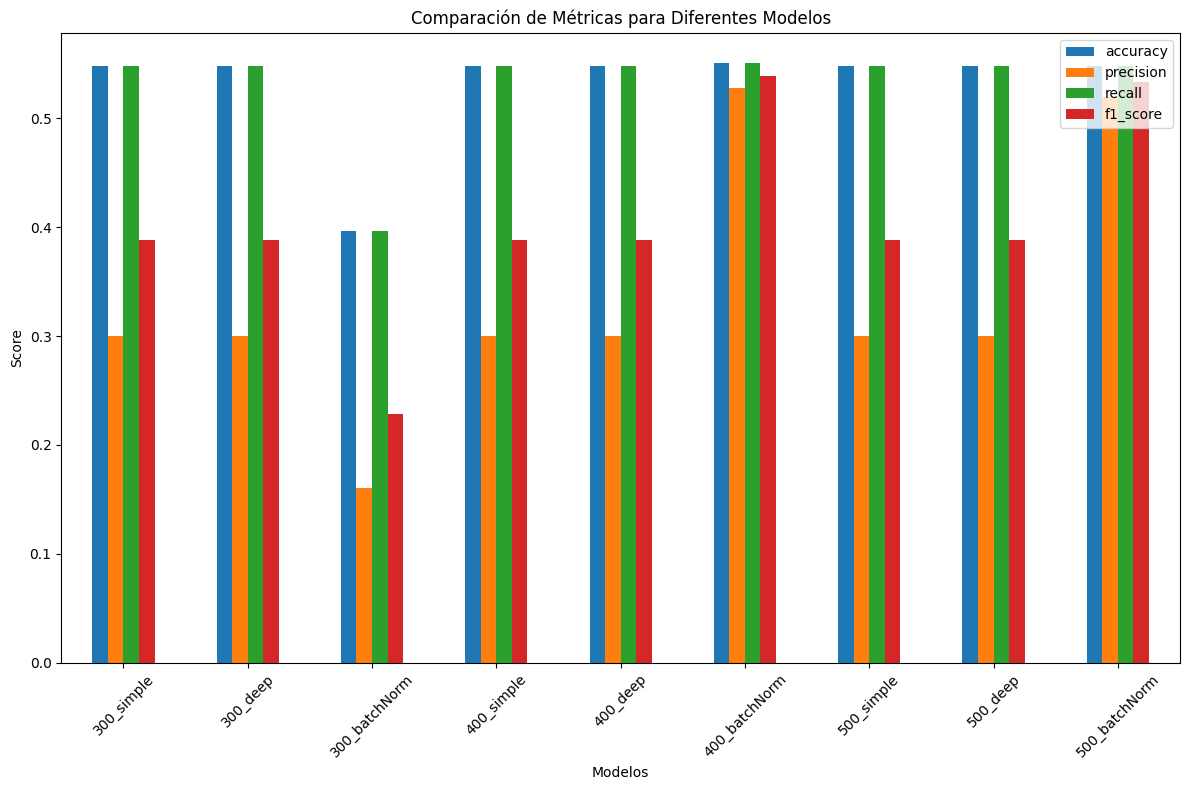

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir a DataFrame
df = pd.DataFrame(results).T

# Crear gráficos comparativos
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
df[metrics].plot(kind='bar', figsize=(12, 8))
plt.title('Comparación de Métricas para Diferentes Modelos')
plt.ylabel('Score')
plt.xlabel('Modelos')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()

# Mostrar gráfico
plt.show()